In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from moviepy.editor import VideoFileClip
%matplotlib inline
#%matplotlib qt

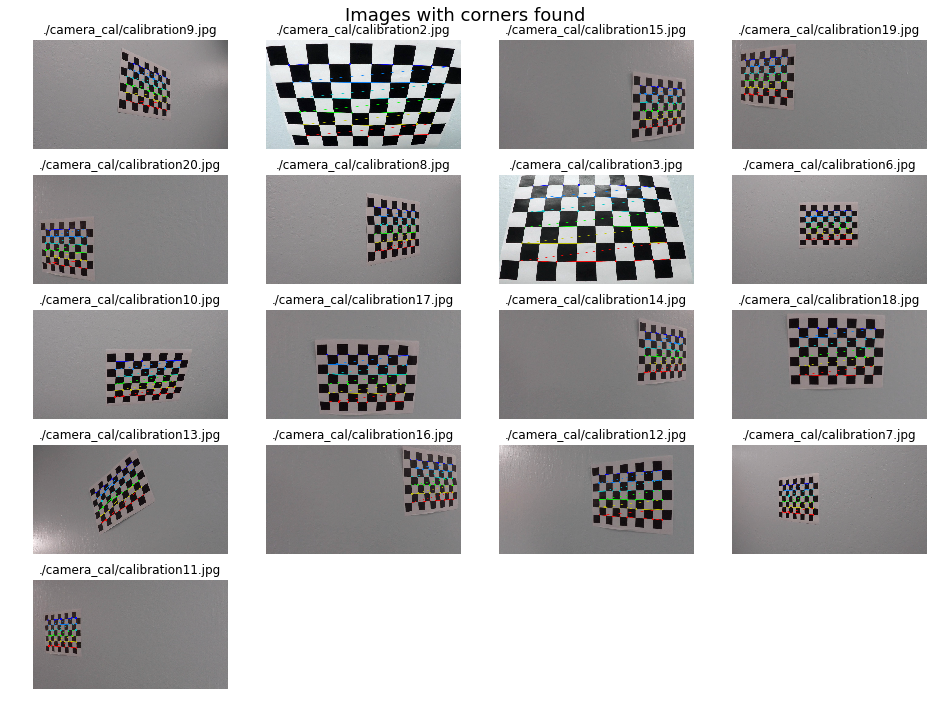

In [2]:
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('./camera_cal/calibration*.jpg')

plt.figure(figsize=(16, 12)) 
plt.figtext(0.5,0.9,'Images with corners found', fontsize=18, ha='center')
# Step through the list and search for chessboard corners
for i, fname in enumerate(images):
    #print(i)
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        plt.subplot(5, 4, len(imgpoints))
        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        plt.imshow(img)
        plt.title(fname)
        plt.axis('off')
        #cv2.imshow('img',img)
        #cv2.waitKey(500)
plt.show()
#cv2.destroyAllWindows()
#print(objpoints)
#print(imgpoints)

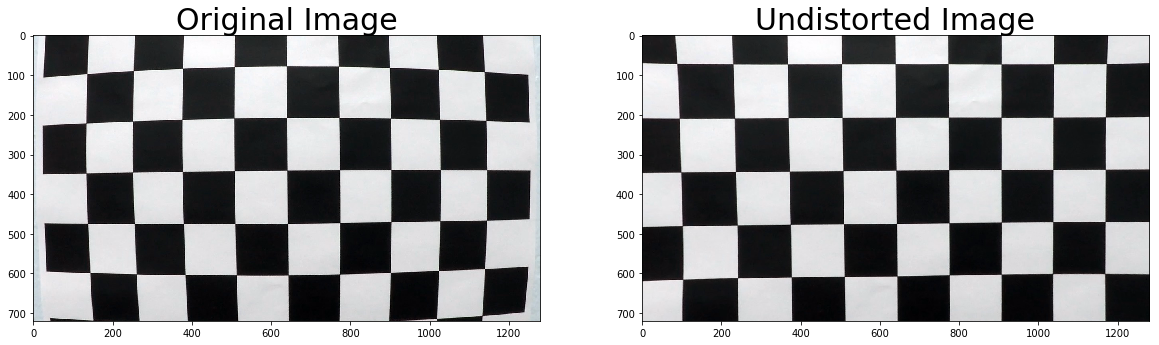

In [3]:
import pickle
%matplotlib inline

# Test undistortion on an image
img = cv2.imread('./camera_cal/calibration1.jpg')
img_size = (img.shape[1], img.shape[0])

# Do camera calibration given object points and image points
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)

dst = cv2.undistort(img, mtx, dist, None, mtx)
cv2.imwrite('./camera_cal/after_calibration/calibration1_undist.jpg',dst)

# Save the camera calibration result for later use (we won't worry about rvecs / tvecs)
dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist
pickle.dump( dist_pickle, open( "camera_cal/calibration_pickle.p", "wb" ) )
#dst = cv2.cvtColor(dst, cv2.COLOR_BGR2RGB)
# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=30)

In [4]:
dist_pickle = pickle.load( open( "./camera_cal/calibration_pickle.p", "rb" ) )
mtx = dist_pickle["mtx"]
dist = dist_pickle["dist"]

img = cv2.imread('./camera_cal/calibration1.jpg')
nx = 9 # the number of inside corners in x
ny = 5 # the number of inside corners in y

In [5]:
# Define a function that takes an image, number of x and y points, 
# camera matrix and distortion coefficients
def corners_unwarp(img, nx, ny, mtx, dist):
    # Use the OpenCV undistort() function to remove distortion
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    # Convert undistorted image to grayscale
    gray = cv2.cvtColor(undist, cv2.COLOR_BGR2GRAY)
    # Search for corners in the grayscaled image
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)

    #print('aaaa')
    print(ret)
    if ret == True:
        # If we found corners, draw them! (just for fun)
        cv2.drawChessboardCorners(undist, (nx, ny), corners, ret)
        # Choose offset from image corners to plot detected corners
        # This should be chosen to present the result at the proper aspect ratio
        # My choice of 100 pixels is not exact, but close enough for our purpose here
        offset = 100 # offset for dst points
        # Grab the image shape
        img_size = (gray.shape[1], gray.shape[0])

        # For source points I'm grabbing the outer four detected corners
        src = np.float32([corners[0], corners[nx-1], corners[-1], corners[-nx]])
        # For destination points, I'm arbitrarily choosing some points to be
        # a nice fit for displaying our warped result 
        # again, not exact, but close enough for our purposes
        dst = np.float32([[offset, offset], [img_size[0]-offset, offset], 
                                     [img_size[0]-offset, img_size[1]-offset], 
                                     [offset, img_size[1]-offset]])
        # Given src and dst points, calculate the perspective transform matrix
        M = cv2.getPerspectiveTransform(src, dst)
        #print('bbb')
        # Warp the image using OpenCV warpPerspective()
        warped = cv2.warpPerspective(undist, M, img_size)

    # Return the resulting image and matrix
    return warped, M

True


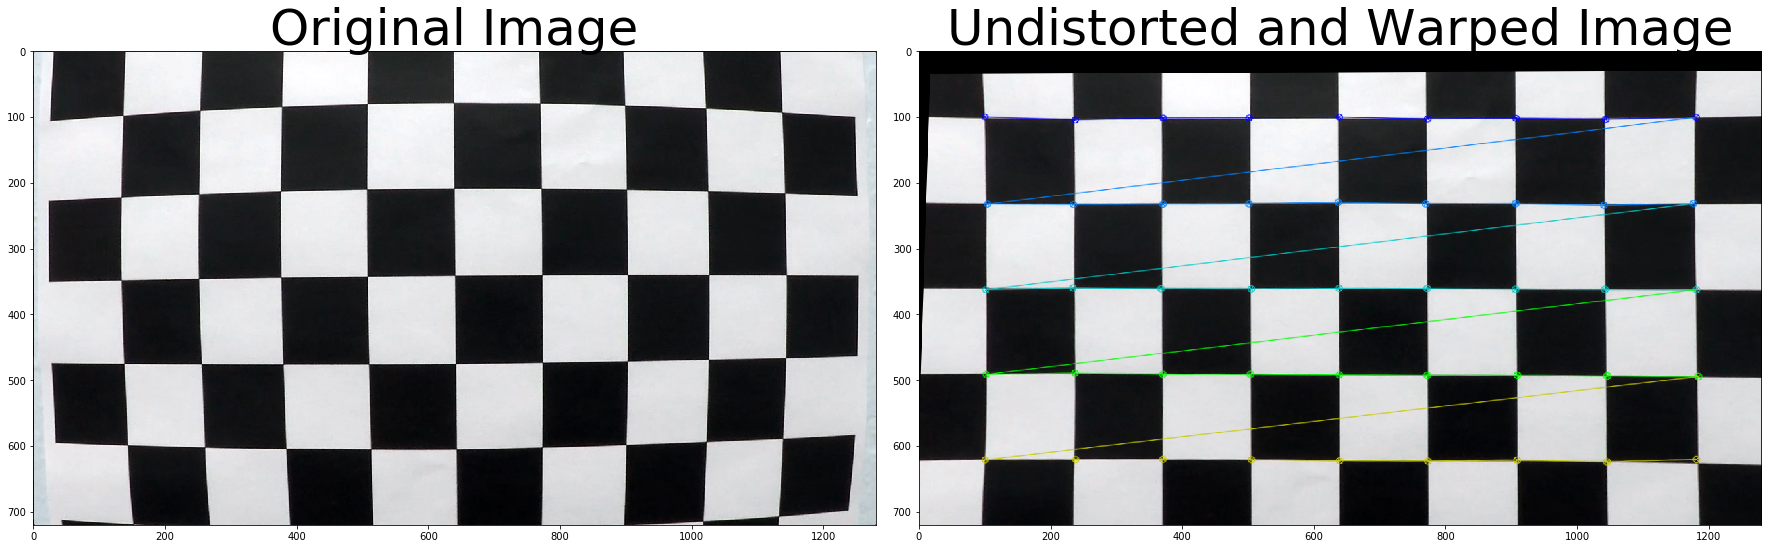

In [6]:
top_down, perspective_M = corners_unwarp(img, nx, ny, mtx, dist)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(top_down)
ax2.set_title('Undistorted and Warped Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

# Image undistortion on one of the test images

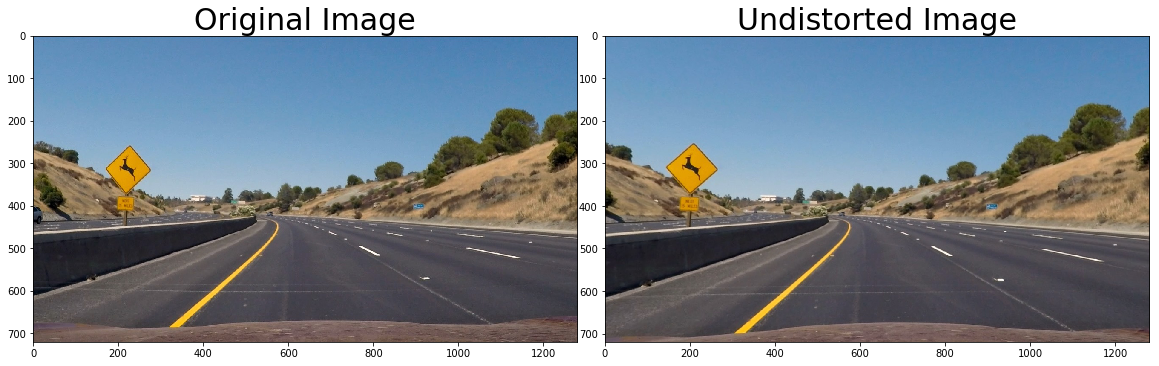

In [9]:
#test_img = mpimg.imread('./test_images/straight_lines2.jpg')
test_img = mpimg.imread('./test_images/test2.jpg')

test_img_undist = cv2.undistort(test_img, mtx, dist, None, mtx)
r,g,b = cv2.split(test_img_undist)       # get b,g,r
test_img_undist_bgr = cv2.merge([b,g,r])     # switch it to rgb. so that the imshow can display correctly
cv2.imwrite('./test_images/test2_undist.jpg',test_img_undist_bgr)


f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
f.subplots_adjust(hspace = .2, wspace=.05)
ax1.imshow(test_img)
h, w = test_img.shape[0], test_img.shape[1]
ax1.set_ylim([h,0])
ax1.set_xlim([0,w])
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(test_img_undist)
ax2.set_title('Undistorted Image', fontsize=30)

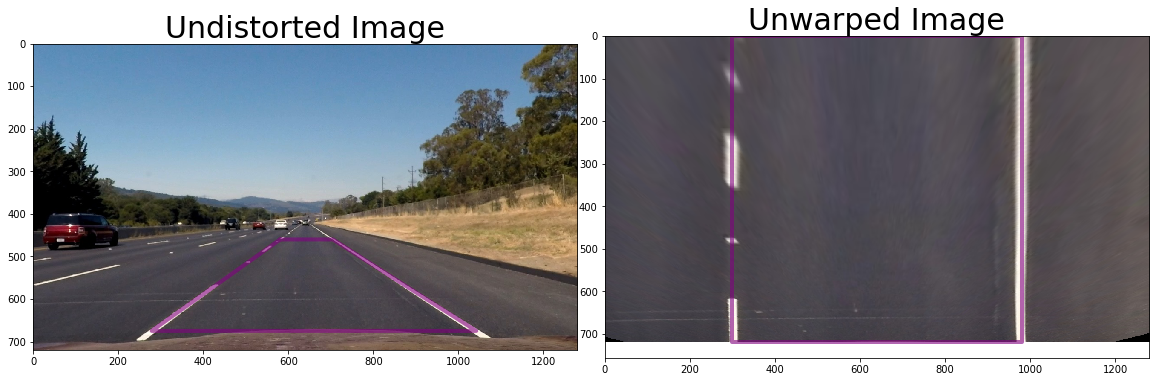

In [10]:

test_img = mpimg.imread('./test_images/straight_lines2.jpg')

test_img_undist = cv2.undistort(test_img, mtx, dist, None, mtx)
r,g,b = cv2.split(test_img_undist)       # get b,g,r
test_img_undist_bgr = cv2.merge([b,g,r])     # switch it to rgb. so that the imshow can display correctly
cv2.imwrite('./test_images/straight_lines2_undist.jpg',test_img_undist_bgr)

h = test_img.shape[0]
w = test_img.shape[1]

#src = np.float32([(602,445), (681,445), (316,650), (1000,650)])
src = np.float32([(581,460), (705,460), (279,675), (1042,675)])
dst = np.float32([(300,0), (w-300,0), (300,h), (w-300,h)])

def unwarp(img, src, dst):
    img_size = (img.shape[1], img.shape[0])
    M = cv2.getPerspectiveTransform(src, dst)   
    M_inv = cv2.getPerspectiveTransform(dst, src)
    warped = cv2.warpPerspective(img, M, img_size)
    
    return warped, M, M_inv  

test_img_undist_warped, M, M_inv = unwarp(test_img_undist, src, dst)

# Visualize unwarp
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
f.subplots_adjust(hspace = .2, wspace=.05)
ax1.imshow(test_img_undist)
x = [src[0][0],src[2][0],src[3][0],src[1][0],src[0][0]]
y = [src[0][1],src[2][1],src[3][1],src[1][1],src[0][1]]
ax1.plot(x, y, color='purple', alpha=0.6, linewidth=4, solid_capstyle='round', zorder=2)
ax1.set_ylim([h,0])
ax1.set_xlim([0,w])
ax1.set_title('Undistorted Image', fontsize=30)

ax2.imshow(test_img_undist_warped)
x2 = [dst[0][0],dst[2][0],dst[3][0],dst[1][0],dst[0][0]]
y2 = [dst[0][1],dst[2][1],dst[3][1],dst[1][1],dst[0][1]]
ax2.plot(x2, y2, color='purple', alpha=0.6, linewidth=4, solid_capstyle='round', zorder=2)
ax2.set_title('Unwarped Image', fontsize=30)


# Define a function that applies Sobel x or y, then takes an absolute value and applies a threshold.

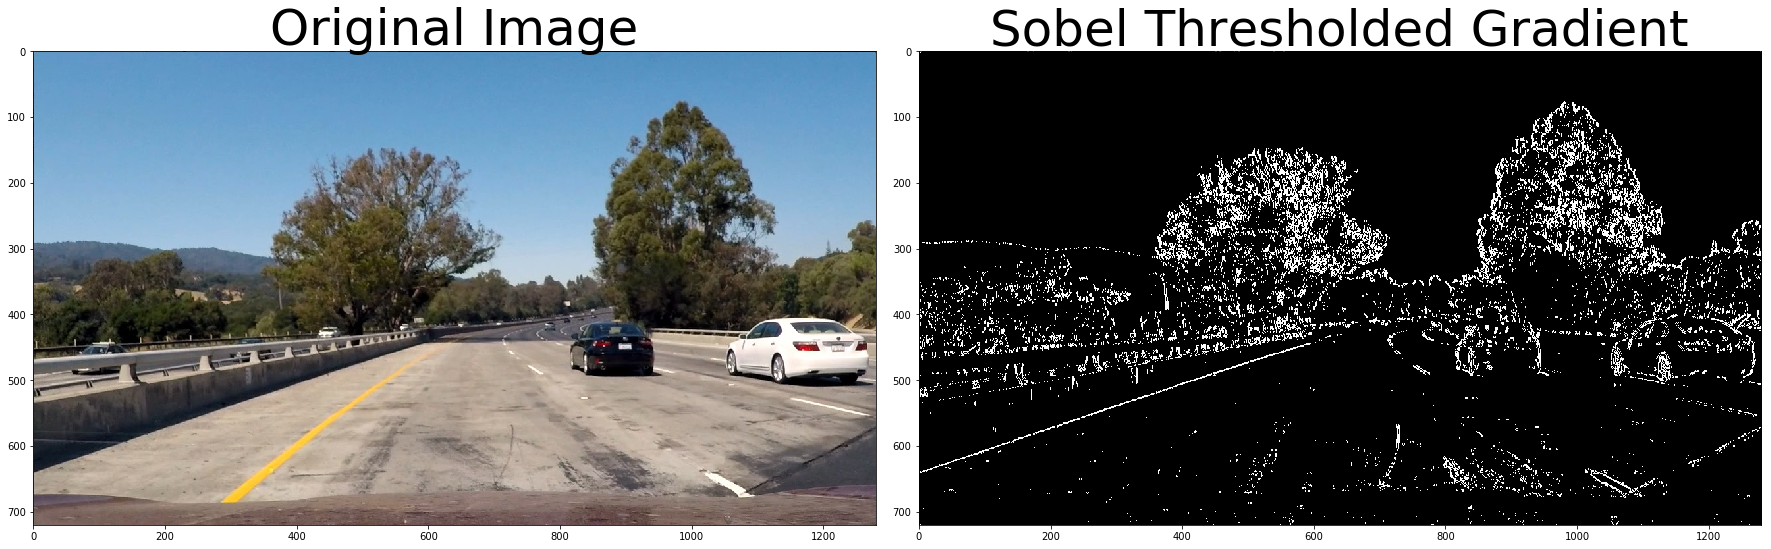

In [11]:
# Define a function that applies Sobel x or y, 
# then takes an absolute value and applies a threshold.
# Note: calling your function with orient='x', thresh_min=5, thresh_max=100

image = cv2.imread('./test_images/test1.jpg')

def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1

    # Return the result
    return binary_output

# Run the function
grad_binary = abs_sobel_thresh(image, orient='x', sobel_kernel=3, thresh=(20, 100))
#grad_binary = abs_sobel_thresh(image, orient='y', sobel_kernel=3, thresh=(0, 40))
# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

b,g,r = cv2.split(image)       # get b,g,r
image = cv2.merge([r,g,b])     # switch it to rgb. so that the imshow can display correctly

ax1.imshow(image)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(grad_binary, cmap ='gray' )
ax2.set_title('Sobel Thresholded Gradient', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

# Define a function to return the magnitude of the gradient for a given sobel kernel size and threshold values

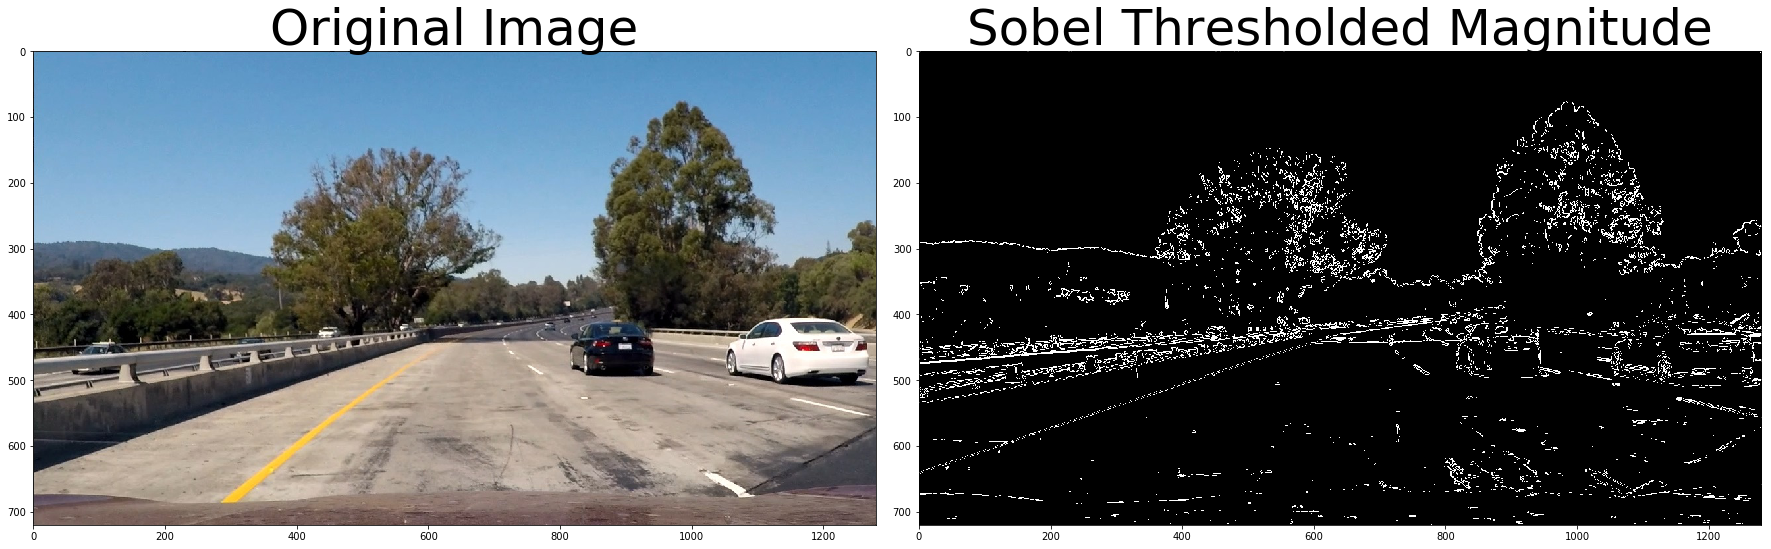

In [12]:
# Read in an image
image = mpimg.imread('./test_images/test1.jpg')

# Define a function that applies Sobel x and y, 
# then computes the magnitude of the gradient
# and applies a threshold
def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1

    # Return the binary image
    return binary_output

    
# Run the function
mag_binary = mag_thresh(image, sobel_kernel=3, mag_thresh=(40, 80))
# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(mag_binary, cmap='gray')
ax2.set_title('Sobel Thresholded Magnitude', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

# Define a function to threshold an image for a given range and Sobel kernel

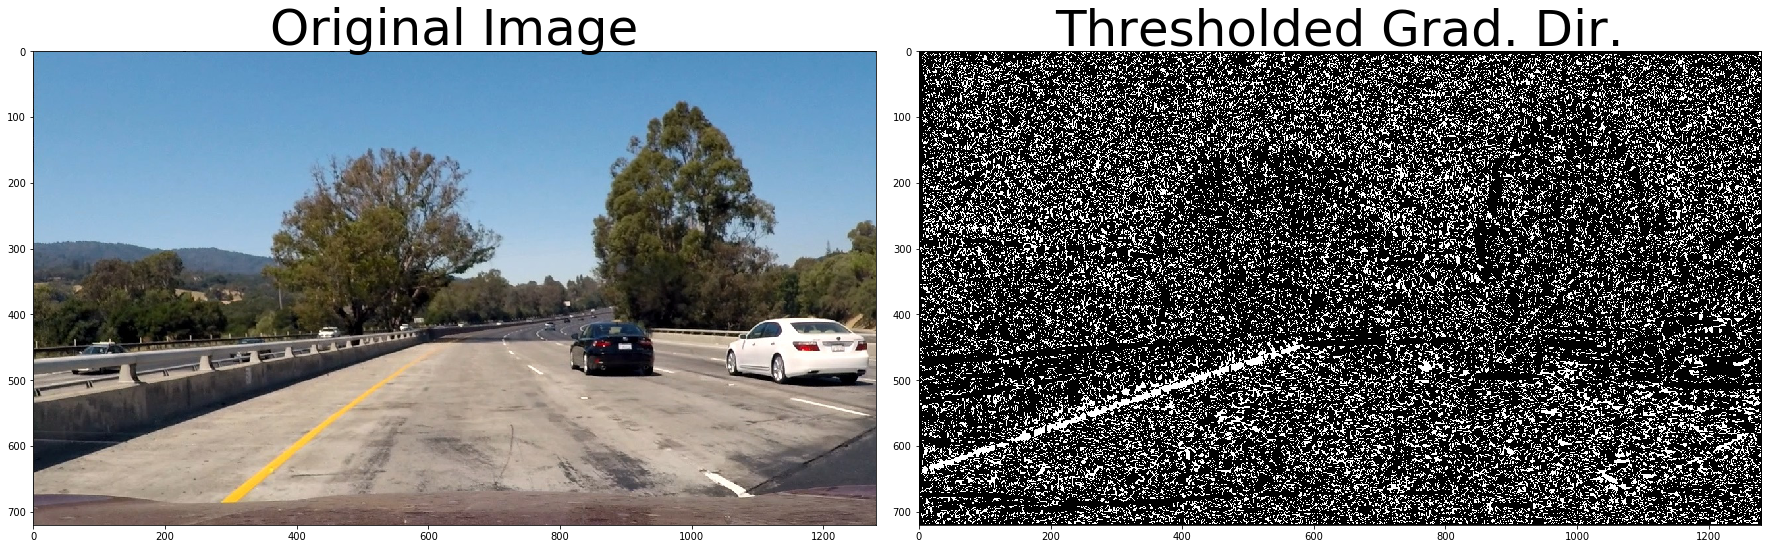

In [13]:
# Read in an image
image = mpimg.imread('./test_images/test1.jpg')

# Define a function that applies Sobel x and y, 
# then computes the direction of the gradient
# and applies a threshold.
def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1

    # Return the binary image
    return binary_output
    
# Run the function
dir_binary = dir_threshold(image, sobel_kernel=15, thresh=(1.0, 1.3))
# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(dir_binary, cmap='gray')
ax2.set_title('Thresholded Grad. Dir.', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

# Combining and applying each of the thresholding functions defined above

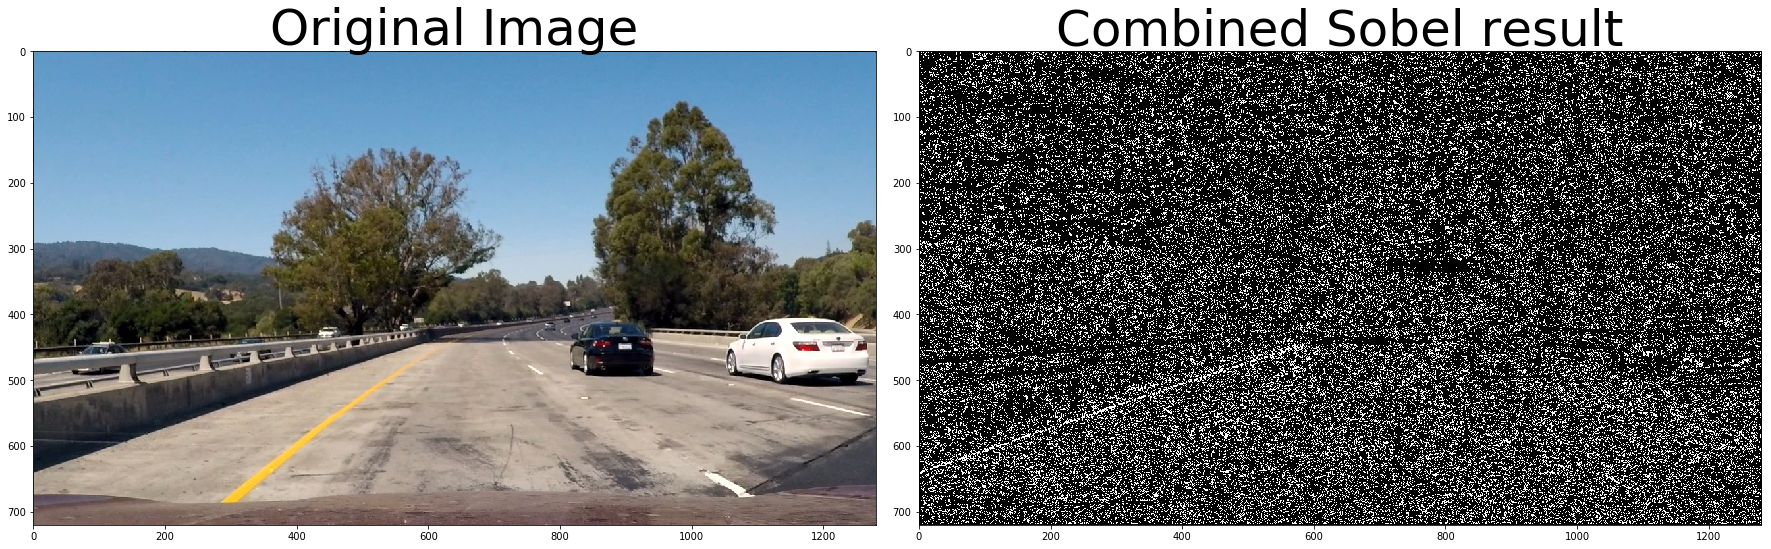

In [14]:
image = mpimg.imread('./test_images/test1.jpg')

ksize = 3

# Apply each of the thresholding functions
gradx = abs_sobel_thresh(image, orient='x', sobel_kernel=ksize, thresh=(20, 100))
grady = abs_sobel_thresh(image, orient='y', sobel_kernel=ksize, thresh=(0, 20))
mag_binary = mag_thresh(image, sobel_kernel=ksize, mag_thresh=(40, 80))
dir_binary = dir_threshold(image, sobel_kernel=ksize, thresh=(1.0, 1.3))

combined = np.zeros_like(dir_binary)
combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(dir_binary, cmap='gray')
ax2.set_title('Combined Sobel result', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

# Define a function that thresholds the S-channel of HLS, Use exclusive lower bound (>) and inclusive upper (<=)

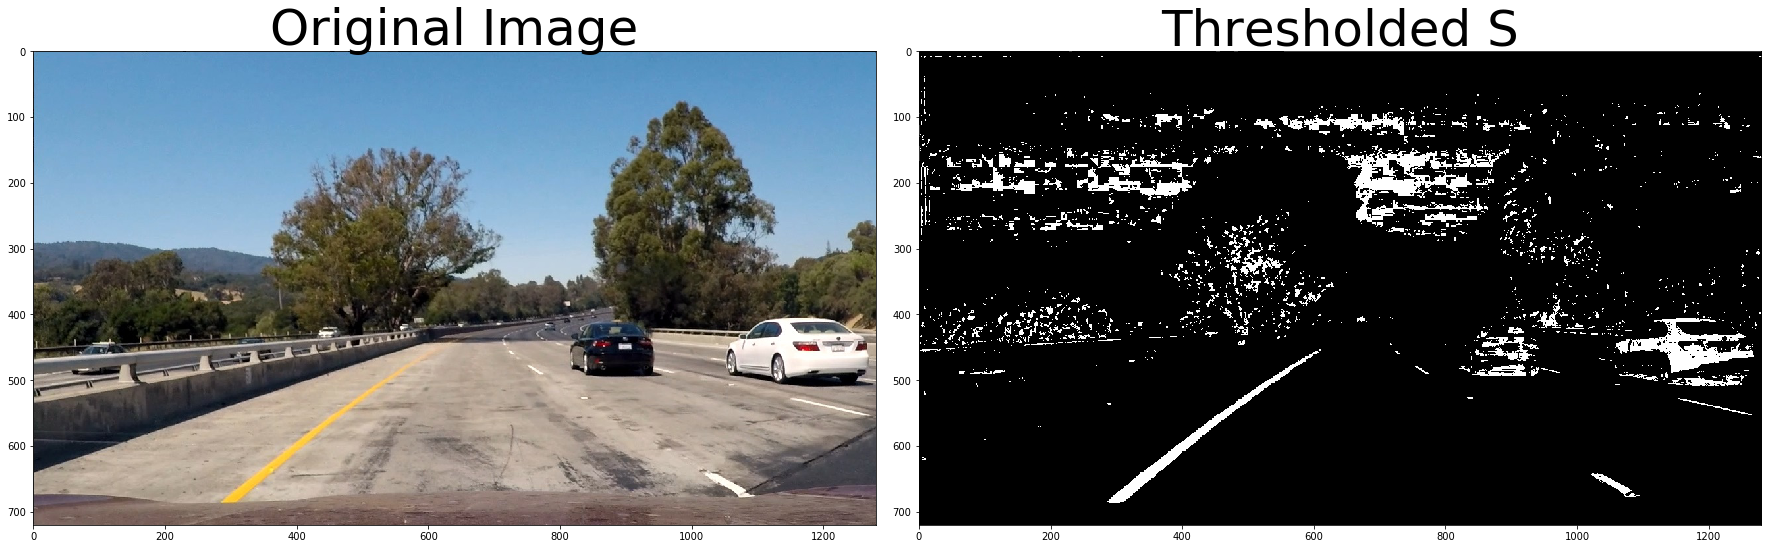

In [15]:
image = mpimg.imread('./test_images/test1.jpg') 

# Define a function that thresholds the S-channel of HLS
# Use exclusive lower bound (>) and inclusive upper (<=)
def hls_select(img, thresh=(0, 255)):
    # 1) Convert to HLS color space
    # 2) Apply a threshold to the S channel
    # 3) Return a binary image of threshold result        
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    binary_output = np.zeros_like(s_channel)
    binary_output[(s_channel > thresh[0]) & (s_channel <= thresh[1])] = 1
    return binary_output

hls_binary = hls_select(image, thresh=(130, 255))

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(hls_binary, cmap='gray')
ax2.set_title('Thresholded S', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

# Define a function that thresholds the red-channel of RGB

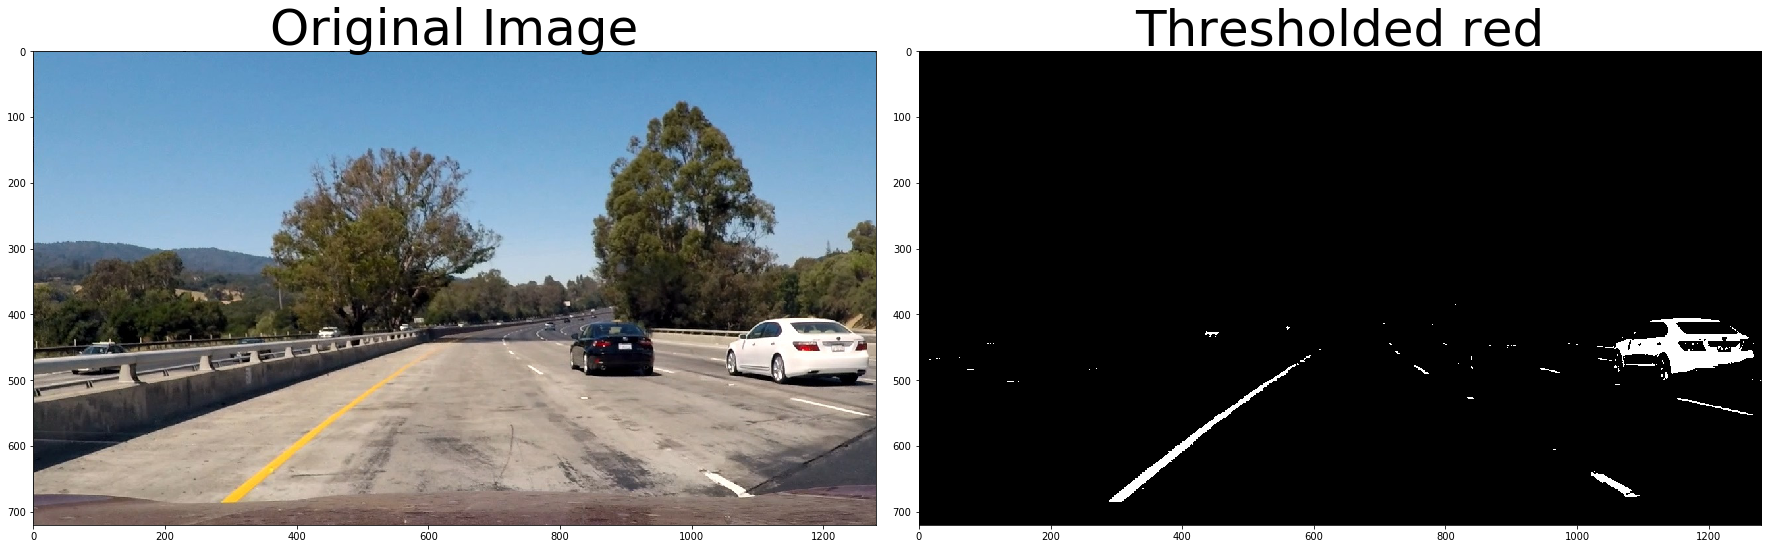

In [17]:
image = mpimg.imread('./test_images/test1.jpg') 

# Define a function that thresholds the red-channel of RGB
def red_select(img, thresh=(0, 255)):
    R = img[:,:,0]
    G = img[:,:,1]
    B = img[:,:,2]
    binary = np.zeros_like(R)
    binary[(R > thresh[0]) & (R <= thresh[1])] = 1
    return binary

red_binary = red_select(image, thresh=(230, 255))

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(red_binary, cmap='gray')
ax2.set_title('Thresholded red', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

# Combine the HSL and Sobel gradient X filters

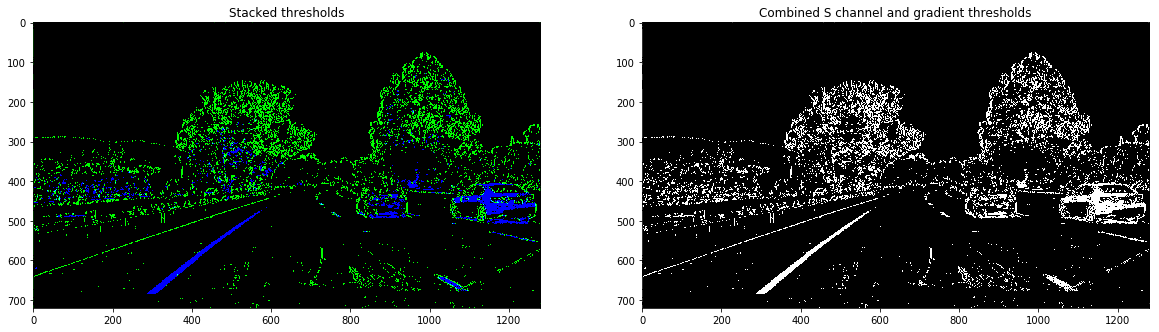

In [18]:
image = mpimg.imread('./test_images/test1.jpg')

ksize = 3

# Apply each of the thresholding functions
gradx = abs_sobel_thresh(image, orient='x', sobel_kernel=ksize, thresh=(20, 100))
hls_binary = hls_select(image, thresh=(160, 255))

# Stack each channel to view their individual contributions in green and blue respectively
# This returns a stack of the two binary images, whose components you can see as different colors
color_binary = np.dstack(( np.zeros_like(gradx), gradx, hls_binary)) * 255

# Combine the two binary thresholds
combined_binary = np.zeros_like(gradx)
combined_binary[(hls_binary == 1) | (gradx == 1)] = 1


# Plotting thresholded images
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.set_title('Stacked thresholds')
ax1.imshow(color_binary)

ax2.set_title('Combined S channel and gradient thresholds')
ax2.imshow(combined_binary, cmap='gray')

# Combine the Saturation and Red channel filters

(720, 1280)
1280


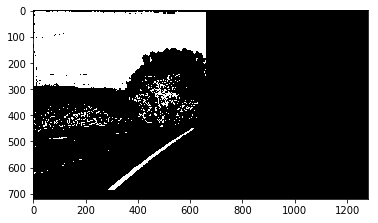

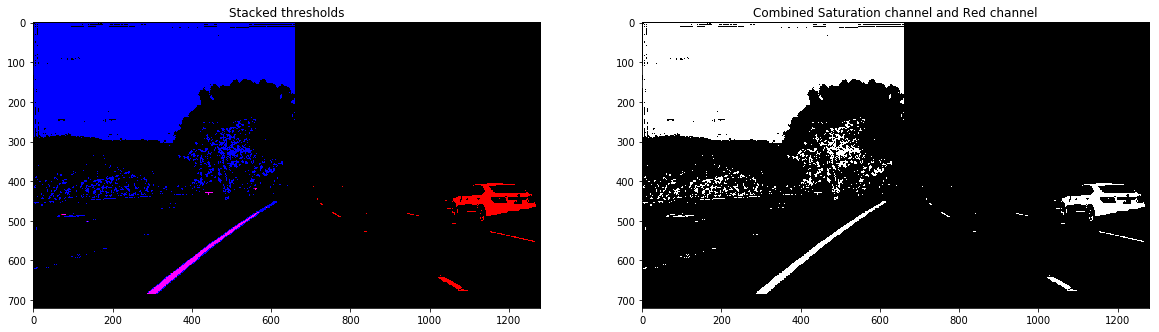

In [19]:

image = mpimg.imread('./test_images/test1.jpg')
#image = mpimg.imread('./test_images/test2.jpg')

ksize = 3

# Apply each of the thresholding functions
# Used to use (215, 255)  (110, 255). The combined binary result is bad
red_binary = red_select(image, thresh=(235, 255))
hls_binary = hls_select(image, thresh=(115, 255))

# Mask the right half as zero (black) 
# meaning only use the hls results for the left half of the image
# Therefore, the yellow lane is detected using the combination of both red_binary and hls_binary
# While the white lane is only detected using the red_binary
l_r_midpoint = 660
w = hls_binary.shape[1]
print(hls_binary.shape)
print(w)
hls_binary[:, l_r_midpoint:w] = 0

plt.imshow(hls_binary, cmap='gray')


# Stack each channel to view their individual contributions in green and blue respectively
# This returns a stack of the two binary images, whose components you can see as different colors
color_binary = np.dstack((red_binary, np.zeros_like(red_binary), hls_binary)) * 255

# Combine the two binary thresholds
combined_binary = np.zeros_like(red_binary)
combined_binary[(hls_binary == 1) | (red_binary == 1)] = 1


# Plotting thresholded images
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.set_title('Stacked thresholds')
ax1.imshow(color_binary)

ax2.set_title('Combined Saturation channel and Red channel')
ax2.imshow(combined_binary, cmap='gray')

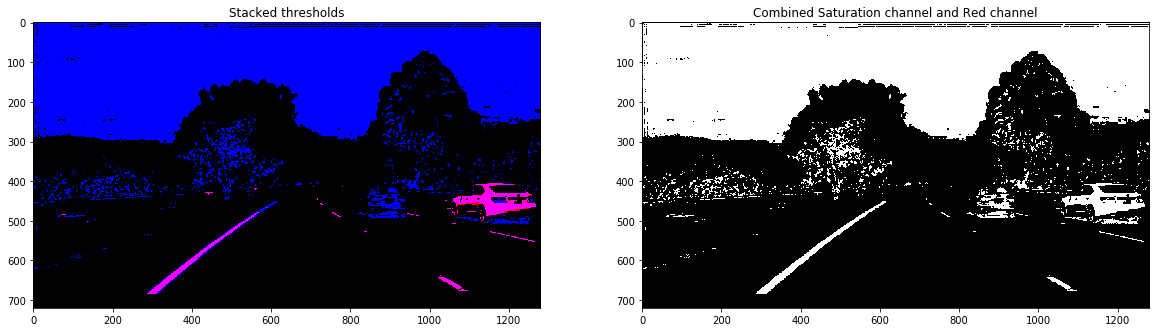

In [20]:
image = mpimg.imread('./test_images/test1.jpg')
#image = mpimg.imread('./test_images/test2.jpg')

ksize = 3

# Apply each of the thresholding functions
# Used to use (215, 255)  (110, 255). The combined binary result is bad
red_binary = red_select(image, thresh=(235, 255))
hls_binary = hls_select(image, thresh=(115, 255))


# Stack each channel to view their individual contributions in green and blue respectively
# This returns a stack of the two binary images, whose components you can see as different colors
color_binary = np.dstack((red_binary, np.zeros_like(red_binary), hls_binary)) * 255

# Combine the two binary thresholds
combined_binary = np.zeros_like(red_binary)
combined_binary[(hls_binary == 1) | (red_binary == 1)] = 1


# Plotting thresholded images
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.set_title('Stacked thresholds')
ax1.imshow(color_binary)

ax2.set_title('Combined Saturation channel and Red channel')
ax2.imshow(combined_binary, cmap='gray')

# Do un-distortion and un-warping on the binary image

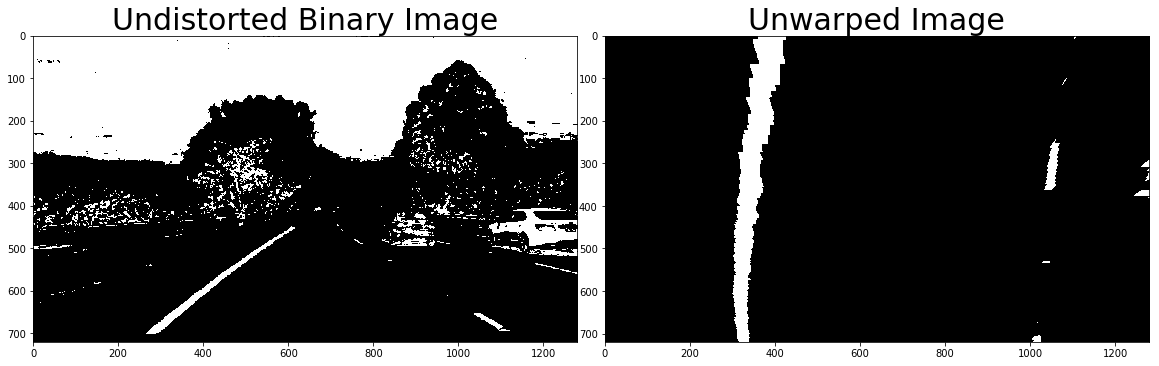

In [21]:
combined_binary_undist = cv2.undistort(combined_binary, mtx, dist, None, mtx)
combined_binary_undist_warped, M, M_inv = unwarp(combined_binary_undist, src, dst)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
f.subplots_adjust(hspace = .2, wspace=.05)

ax1.imshow(combined_binary_undist, cmap='gray')
ax1.set_title('Undistorted Binary Image', fontsize=30)
ax1.set_ylim([h,0])
ax1.set_xlim([0,w])
ax2.imshow(combined_binary_undist_warped, cmap='gray')
ax2.set_title('Unwarped Image', fontsize=30)

# Define the polyfit based on the non-zero pixel counting and histogram generation

In [24]:
def histogram_polyfit(image):
    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    histogram = np.sum(image[image.shape[0]//3:,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((image, image, image))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 12
    # Set height of windows
    window_height = np.int(image.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = image.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 40
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    rectangles = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = image.shape[0] - (window+1)*window_height
        win_y_high = image.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        rectangles.append((win_y_low, win_y_high, win_xleft_low, win_xleft_high, win_xright_low, win_xright_high))
        # Draw the windows on the visualization image
        #cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
        #(0,255,0), 2) 
        #cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
        #(0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    left_fit, right_fit = (None, None)
    # Fit a second order polynomial to each
    #left_fit = np.polyfit(lefty, leftx, 2)    
    #right_fit = np.polyfit(righty, rightx, 2)
        
    if len(leftx) != 0:
        left_fit = np.polyfit(lefty, leftx, 2)
    if len(rightx) != 0:    
        right_fit = np.polyfit(righty, rightx, 2)
    
    
    return left_fit, right_fit, left_lane_inds, right_lane_inds, rectangles

(720, 0)

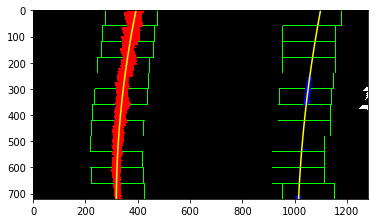

In [25]:
# Generate x and y values for plotting
left_fit, right_fit, left_lane_inds, right_lane_inds, rectangles = histogram_polyfit(combined_binary_undist_warped)

# Create an output image to draw on and  visualize the result
out_img = np.uint8(np.dstack((combined_binary_undist_warped, combined_binary_undist_warped, combined_binary_undist_warped))*255)

ploty = np.linspace(0, combined_binary_undist_warped.shape[0]-1, combined_binary_undist_warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

for rect in rectangles:
# Draw the windows on the visualization image
    cv2.rectangle(out_img,(rect[2],rect[0]),(rect[3],rect[1]),(0,255,0), 2) 
    cv2.rectangle(out_img,(rect[4],rect[0]),(rect[5],rect[1]),(0,255,0), 2) 
    
# Identify the x and y positions of all nonzero pixels in the image
nonzero = combined_binary_undist_warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])

out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

# Perform the polyfit based on the calculation of the histogram

In [26]:
def last_frame_polyfit(binary_warped, left_fit_prev, right_fit_prev):
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    left_lane_inds = ((nonzerox > (left_fit_prev[0]*(nonzeroy**2) + left_fit_prev[1]*nonzeroy + 
    left_fit_prev[2] - margin)) & (nonzerox < (left_fit_prev[0]*(nonzeroy**2) + 
    left_fit_prev[1]*nonzeroy + left_fit_prev[2] + margin))) 

    right_lane_inds = ((nonzerox > (right_fit_prev[0]*(nonzeroy**2) + right_fit_prev[1]*nonzeroy + 
    right_fit_prev[2] - margin)) & (nonzerox < (right_fit_prev[0]*(nonzeroy**2) + 
    right_fit_prev[1]*nonzeroy + right_fit_prev[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    # Fit a second order polynomial to each
    #left_fit = np.polyfit(lefty, leftx, 2)
    #right_fit = np.polyfit(righty, rightx, 2)
    
    left_fit, right_fit = (None, None)
    if len(leftx) != 0:
        # Fit a second order polynomial to each
        left_fit = np.polyfit(lefty, leftx, 2)
    if len(rightx) != 0:
        right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    #ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    #left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    #right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    return left_fit, right_fit, left_lane_inds, right_lane_inds

# Define the function for calcuating the curvature

In [29]:
# Define y-value where we want radius of curvature
# I'll choose the maximum y-value, corresponding to the bottom of the image
def curvature(binary_img, left_fit, right_fit, left_lane_inds, right_lane_inds):
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension 
    left_curverad, right_curverad = (0, 0)
    
    ploty = np.linspace(0, binary_img.shape[0]-1, binary_img.shape[0] )
    
    y_eval = np.max(ploty)
    #left_fit_cr = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    #right_fit_cr = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    if len(leftx) != 0 and len(rightx) != 0:
        #left_fit_cr = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)
        #right_fit_cr = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2)
        left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
        right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)

        # curvation in meters
        # Calculate the new radii of curvature
        left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
        right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    
    return left_curverad, right_curverad

In [31]:
lef_curv, right_curv = curvature(combined_binary_undist_warped, left_fit, right_fit, left_lane_inds, right_lane_inds)

print('Radius of curvature:', lef_curv, 'm,', right_curv, 'm')

Radius of curvature: 1206.10782033 m, 1672.30773402 m


# Define the function for calcuating the distance to lane center

In [32]:
def center_dist(binary_img, left_fit, right_fit):
    center_dist = 0
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    if right_fit is not None and left_fit is not None:
        car_position = binary_img.shape[1]/2
        l_fit_x_int = left_fit[0]*h**2 + left_fit[1]*h + left_fit[2]
        r_fit_x_int = right_fit[0]*h**2 + right_fit[1]*h + right_fit[2]
        lane_center_position = (r_fit_x_int + l_fit_x_int) /2
        center_dist = (car_position - lane_center_position) * xm_per_pix
    return center_dist

In [33]:
center_distance = center_dist(combined_binary_undist_warped, left_fit, right_fit)
print('Distance from lane center:', center_distance, 'm')

Distance from lane center: -0.140696713948 m


# Define the function for plotting the results/data back to the original image

In [34]:
def draw_results(orig_img, binary_img, left_fit, right_fit, M_inv, curve, center_distance):
    
    if left_fit is None or right_fit is None:
        return orig_img
    
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(binary_img).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    
    ploty = np.linspace(0, binary_img.shape[0]-1, binary_img.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (M_inv)
    newwarp = cv2.warpPerspective(color_warp, M_inv, (image.shape[1], image.shape[0])) 
    
    img_copy = np.copy(orig_img)
    # Combine the result with the original image
    img_with_lane = cv2.addWeighted(img_copy, 1, newwarp, 0.4, 0)
    
    # Add the result text in the image
    new_img = np.copy(img_with_lane)
    h = img_with_lane.shape[0]
    font = cv2.FONT_HERSHEY_DUPLEX
    text = 'curve radius: ' + '{:04.2f}'.format(curve) + 'm'
    cv2.putText(img_with_lane, text, (10,50), font, 1.5, (255,255,200), 2)

    abs_center_dist = abs(center_distance)
    text = '{:04.3f}'.format(abs_center_dist) + 'm ' + 'from center'
    cv2.putText(img_with_lane, text, (10,100), font, 1.5, (255,255,200), 2)
    
    return img_with_lane

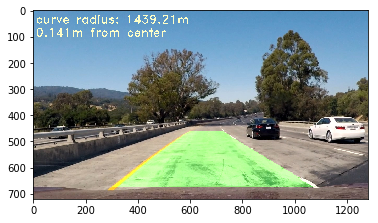

In [35]:
curve = (lef_curv+right_curv)/2
image_with_lanes = draw_results(image, combined_binary_undist_warped, left_fit, right_fit, M_inv, curve, center_distance)
plt.imshow(image_with_lanes)

# Define a class for holding the lane detection related values

In [36]:
# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = []  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
    def update_fit(self, fit, inds):        
        # Maintain a group of last 4 fits; Add the fit to the fit group is it exists
        if fit is not None:
            #print('add fit aaa')
            if self.best_fit is not None:
                self.diffs = abs(fit-self.best_fit)
            if (self.diffs[0] > 0.001 or self.diffs[1] > 1.0 or self.diffs[2] > 100.) and len(self.current_fit) > 0:
                self.detected = False
            else:
                self.detected = True
                self.current_fit.append(fit)
                if len(self.current_fit) > 4:
                    # throw out old fits, keep newest n
                    self.current_fit = self.current_fit[len(self.current_fit)-4:]
                self.best_fit = np.average(self.current_fit, axis=0)
        # if no fit is found, remove one fit from the group (the oldest one)
        else:
            #print('add fit bbb')
            self.detected = False
            if len(self.current_fit) > 0:
                # remove oldest fit
                self.current_fit = self.current_fit[:len(self.current_fit)-1]
            if len(self.current_fit) > 0:
                #  best_fit is average of the group of fits
                self.best_fit = np.average(self.current_fit, axis=0)

# Define the function for the overall image processing pipeline

In [37]:
def pipeline(img):
    
    ksize = 3

    '''
    # Apply each of the thresholding functions
    # Used to use (215, 255)  (110, 255). The combined binary result is bad
    #red_binary = red_select(img, thresh=(230, 255))
    #hls_binary = hls_select(img, thresh=(130, 255))
    red_binary = red_select(img, thresh=(215, 255))
    hls_binary = hls_select(img, thresh=(115, 255))
    '''
    
    # Apply each of the thresholding functions
    # Used to use (215, 255)  (110, 255). The combined binary result is bad
    red_binary = red_select(img, thresh=(235, 255))
    hls_binary = hls_select(img, thresh=(115, 255))

    # Mask the right half as zero (black) 
    # meaning only use the hls results for the left half of the image
    # Therefore, the yellow lane is detected using the combination of both red_binary and hls_binary
    # While the white lane is only detected using the red_binary
    l_r_midpoint = 660
    w = hls_binary.shape[1]
    hls_binary[:, l_r_midpoint:w] = 0
    

    # Combine the two binary thresholds
    combined_binary = np.zeros_like(red_binary)
    combined_binary[(hls_binary == 1) | (red_binary == 1)] = 1
    
    
    '''
    h = img.shape[0]
    w = img.shape[1]
    src = np.float32([(602,445), (681,445), (279,675), (1042,675)])
    dst = np.float32([(300,0), (w-300,0), (300,h), (w-300,h)])
    # Undistort
    img_undistort = cv2.undistort(img, mtx, dist, None, mtx)
    #print(img_undistort.shape)
    
    # Perspective Transform
    img_undist_warped, M, M_inv = unwarp(img_undistort, src, dst)
    '''
    # Note that the mtx dist src dst are calculated in the cells at the beginning 
    combined_binary_undist = cv2.undistort(combined_binary, mtx, dist, None, mtx)
    combined_binary_undist_warped, M, M_inv = unwarp(combined_binary_undist, src, dst)
    

    return combined_binary_undist_warped, M_inv

#img_bin, M_inv = pipeline(image)
#plt.imshow(img_bin, cmap ='gray')

# Define the function for transforming each frame of the video

In [39]:
def transform_img(img):
    img_copy = np.copy(img)
    img_bin = np.zeros_like(img_copy)
    img_bin, M_inv = pipeline(img_copy)
    
    # Use histogram_polyfit to re-calculate the fit, if either left or right lines were not detected in last frame   
    if not l_line.detected or not r_line.detected:
        l_fit, r_fit, l_lane_inds, r_lane_inds, _ = histogram_polyfit(img_bin)
    # Calculate the fit from scratch using last_frame_polyfit, if both left and right lines were detected
    else:
        l_fit, r_fit, l_lane_inds, r_lane_inds = last_frame_polyfit(img_bin, l_line.best_fit, r_line.best_fit)
        
    # If the fit jumps too much, do not add that fit
    # jumps too much = difference in x-intercepts > 100 px
    if l_fit is not None and r_fit is not None:
        #print('ccc')
        # calculate x-intercept for fits
        h = img.shape[0]
        l_fit_x_int = l_fit[0]*h**2 + l_fit[1]*h + l_fit[2]
        r_fit_x_int = r_fit[0]*h**2 + r_fit[1]*h + r_fit[2]
        x_int_diff = abs(r_fit_x_int-l_fit_x_int)
        #print(x_int_diff)
        if abs(728 - x_int_diff) > 100:
            #print('ddd')
            l_fit = None
            r_fit = None
            
    l_line.update_fit(l_fit, l_lane_inds)
    r_line.update_fit(r_fit, r_lane_inds)
    
    # Draw the results/data back to the image
    #print(l_line.best_fit)
    #print(r_line.best_fit)
    if l_line.best_fit is not None and r_line.best_fit is not None:
        #print('aaa')
        rad_l, rad_r = curvature(img_bin, l_line.best_fit, r_line.best_fit, l_lane_inds, r_lane_inds)
        d_center = center_dist(img_bin, l_line.best_fit, r_line.best_fit)
        
        img_out = draw_results(img_copy, img_bin, l_line.best_fit, r_line.best_fit, M_inv, (rad_l+rad_r)/2, d_center)
    else:
        #print('bbb')
        img_out = img_copy
    
    return img_out

In [40]:
l_line = Line()
r_line = Line()

video_output1 = 'project_video_output.mp4'
video_input1 = VideoFileClip('project_video.mp4')#.subclip(24,27)
processed_video = video_input1.fl_image(transform_img)
%time processed_video.write_videofile(video_output1, audio=False)

[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


100%|█████████▉| 1260/1261 [01:40<00:00, 12.52it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

CPU times: user 9min 1s, sys: 1.98 s, total: 9min 3s
Wall time: 1min 41s
